# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
base_path = "/content/drive/MyDrive/Rec"

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [47]:
import os
data = pd.read_csv(os.path.join(base_path, 'Train_rev1.csv'),index_col=None)

In [48]:
#data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
148766,70761234,Primary Teachers Longterm or Permanent Februar...,AMDAS EDUCATION Loyalty Bonus paid for long te...,"Penge, London",Penge,part_time,contract,Amdas Consultancy Ltd,Teaching Jobs,115 - 145/day MPS if perm 200 termly bonus,31200,cv-library.co.uk,10.348206
161511,71189882,Ladies Wear Designer Jersey and Wovens,Our client is a leading ladies supplier who a...,North London London South East,North Lambeth,NaN,permanent,Michael Page Design,Creative & Design Jobs,30000 to 40000 per annum,35000,totaljobs.com,10.463132
31265,68073243,IS Project Test Lead,We are looking for a Project Test Lead to be r...,"Chippenham, Wiltshire Wiltshire South West",Chippenham,NaN,permanent,Logistics Job Shop Ltd,Other/General Jobs,40000 per annum + Benefits,40000,totaljobs.com,10.596660


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [49]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [50]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [51]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [52]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
#<YOUR CODE HERE>
for col in text_columns:
    for entry in data[col]:
        token_counts.update(entry.split())


In [53]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

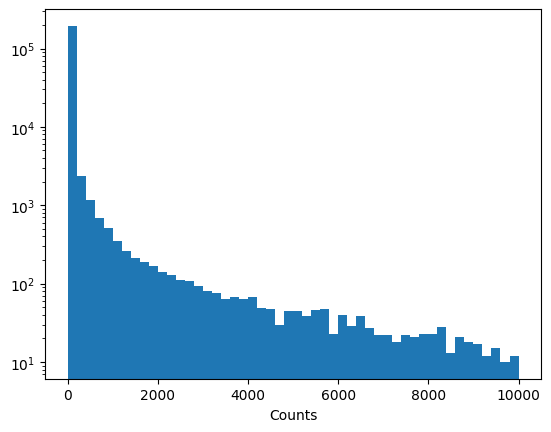

In [54]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [55]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [56]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [57]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}


In [58]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [59]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [60]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [61]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [62]:

from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [63]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)

    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)

    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


In [64]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[1515,  165,   88],
        [  18,  126, 2203],
        [ 390,  748,  748]], dtype=int32),
 'FullDescription': array([[  142,  1515,   165,    88,  3181,  2409,   205,    73,  1951,
          5811],
        [12456,  2241,   561,  1073,  1691,  8524,    57, 13345,  4358,
            15],
        [  390,   748,   561,  1073,  1617,  1566, 12962,    73,   561,
           390]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.959558, 10.915089, 10.126671], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [65]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [66]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        h = F.relu(self.pool1(self.conv1(h)))
        h = F.relu(self.dense(h))
        return h

In [67]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [68]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
#<YOUR CODE HERE>
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h = F.relu(self.pool1(self.conv1(h)))
        h = F.relu(self.dense(h))
        return h


In [69]:
desc_encoder = DescriptionEncoder()


dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [70]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)

        # define layers for categorical features. A few dense layers would do.
        #<YOUR CODE>

        # define "output" layers that process depend the three encoded vectors into answer
        #<YOUR CODE>

        self.cat_dense1 = nn.Linear(n_cat_features, 128)
        self.cat_dense2 = nn.Linear(128, 64)
        self.final_dense1 = nn.Linear(64 * 3, 128)
        self.final_dense2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)


    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """

        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        # apply categorical encoder
        cat_h = F.relu(self.cat_dense2(F.relu(self.cat_dense1(cat_features))))

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top
        joint_h = F.relu(self.final_dense2(F.relu(self.final_dense1(joint_h))))
        result = self.output_layer(joint_h)

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.



        return result[:, 0]

In [71]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [72]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]
print("Well done!")

Well done!


In [73]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [74]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

print('Aigt mate')

Aigt mate


### Let's train it!

In [75]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]

    irange = tnrange if verbose else range

    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [76]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [34]:
for epoch_i in range(num_epochs):

    print("Training:")
    train_loss = train_mae = train_batches = 0
    model.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')

    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	14.26027
	MAE:	44431.08550



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.60206
	MAE:	6526.59840



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.49183
	MAE:	6492.56904



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.37020
	MAE:	5402.14699



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.34361
	MAE:	5568.99330



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.33436
	MAE:	6290.68369



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.25913
	MAE:	4689.92538



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25852
	MAE:	4506.49020



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.28691
	MAE:	5134.42820



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.34388
	MAE:	4775.58384



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22804
	MAE:	4310.14076



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21785
	MAE:	4155.22539



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22270
	MAE:	4323.92250



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25461
	MAE:	5508.45854



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19237
	MAE:	4079.48623



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19317
	MAE:	4356.60874



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18411
	MAE:	4062.80830



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21353
	MAE:	4932.97906



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17920
	MAE:	3886.52927



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16999
	MAE:	3866.31199



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19375
	MAE:	4046.70141



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18606
	MAE:	4442.41120



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17578
	MAE:	4006.24757



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15353
	MAE:	3727.29155



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16726
	MAE:	3884.07357



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15992
	MAE:	3600.42119



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16013
	MAE:	3794.65035



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14727
	MAE:	3533.45099



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15324
	MAE:	3705.43908



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14288
	MAE:	3488.01985



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14551
	MAE:	3603.94471



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13454
	MAE:	3425.96863



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14034
	MAE:	3580.45888



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13573
	MAE:	3571.91475



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14105
	MAE:	3663.72564



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13179
	MAE:	3380.78862



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13856
	MAE:	3591.26049



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16917
	MAE:	4284.83039



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15629
	MAE:	3865.01946



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12905
	MAE:	3340.79132



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16244
	MAE:	3939.69020



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17139
	MAE:	3719.68582



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13648
	MAE:	3466.62417



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12541
	MAE:	3273.85357



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13339
	MAE:	3503.51639



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13266
	MAE:	3342.99831



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13430
	MAE:	3572.08791



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11969
	MAE:	3367.15028



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12467
	MAE:	3484.81709



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15299
	MAE:	4134.47932



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12755
	MAE:	3466.12561



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12859
	MAE:	3317.44427



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12599
	MAE:	3486.79804



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11475
	MAE:	3186.93826



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12309
	MAE:	3345.49969



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15345
	MAE:	4108.45749



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12039
	MAE:	3350.00033



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11896
	MAE:	3192.94264



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12483
	MAE:	3376.67566



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11393
	MAE:	3145.42035



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12745
	MAE:	3322.00979



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13325
	MAE:	3761.29152



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11814
	MAE:	3388.31390



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11207
	MAE:	3270.82618



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11063
	MAE:	3148.28969



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15676
	MAE:	3632.68092



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09962
	MAE:	3019.12634



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10569
	MAE:	3039.50976



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10993
	MAE:	3200.61420



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10575
	MAE:	3038.93689



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11053
	MAE:	3144.48889



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19254
	MAE:	5075.56036



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12297
	MAE:	3377.82334



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10859
	MAE:	3077.88952



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11532
	MAE:	3256.91388



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11034
	MAE:	3097.28719



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11079
	MAE:	3257.01527



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10282
	MAE:	3007.13668



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10681
	MAE:	3111.00413



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10044
	MAE:	3052.93386



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11618
	MAE:	3248.01260



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10397
	MAE:	3134.58387



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10385
	MAE:	3105.36877



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11168
	MAE:	3112.15164



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10383
	MAE:	3140.43161



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10680
	MAE:	3048.45100



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11595
	MAE:	3300.10124



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14571
	MAE:	4062.28380



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13698
	MAE:	3525.47283



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13934
	MAE:	3422.21503



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09880
	MAE:	3022.42272



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11144
	MAE:	3125.76977



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10042
	MAE:	3067.69459



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10183
	MAE:	3126.44909



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11072
	MAE:	3197.43121



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11260
	MAE:	3123.54539



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09863
	MAE:	2998.40722



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09844
	MAE:	3074.13258



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09250
	MAE:	2918.68908



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09516
	MAE:	2911.30061



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09566
	MAE:	2956.10257



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09636
	MAE:	2999.13376



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09721
	MAE:	2975.44258



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10590
	MAE:	3266.78495



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10155
	MAE:	3049.32643



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11119
	MAE:	3109.69930



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09196
	MAE:	2990.08573



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09477
	MAE:	2882.08000



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13511
	MAE:	3514.27842



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10204
	MAE:	2992.39602



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10278
	MAE:	3095.63413



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11121
	MAE:	3100.58319



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09418
	MAE:	3004.61365



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09035
	MAE:	2848.30670



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09970
	MAE:	3015.44495



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09041
	MAE:	2839.73654



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09430
	MAE:	2912.55731



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10701
	MAE:	3294.16650



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09159
	MAE:	2975.34529



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09075
	MAE:	2912.36622



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10188
	MAE:	3072.18759



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09864
	MAE:	2928.07631



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09223
	MAE:	2950.88366



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08979
	MAE:	2888.96200



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09392
	MAE:	2947.35339



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11527
	MAE:	3149.03601



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09917
	MAE:	3121.25833



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08874
	MAE:	2811.96762



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09548
	MAE:	2956.95944



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08943
	MAE:	2926.06033



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08745
	MAE:	2849.05834



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09601
	MAE:	2907.37195



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09588
	MAE:	3012.93568



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09647
	MAE:	3047.47180



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09514
	MAE:	3048.38335



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10035
	MAE:	2973.79995



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09180
	MAE:	2911.80111



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08527
	MAE:	2759.22039



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09000
	MAE:	2892.10823



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08750
	MAE:	2797.11836



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09270
	MAE:	2848.23985



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08658
	MAE:	2843.77490



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08601
	MAE:	2859.44868



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08556
	MAE:	2787.19597



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09248
	MAE:	2932.84914



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09812
	MAE:	2935.32497



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10583
	MAE:	3162.42530



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11530
	MAE:	3151.07220



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08493
	MAE:	2793.84859



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08482
	MAE:	2754.16038



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08634
	MAE:	2839.33478



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08603
	MAE:	2761.90383



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09734
	MAE:	3042.21723



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08887
	MAE:	2804.53611



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08202
	MAE:	2723.11054



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09205
	MAE:	3007.35560



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09745
	MAE:	2978.24110



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08338
	MAE:	2771.32290



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09355
	MAE:	2920.46774



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08383
	MAE:	2774.67195



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08423
	MAE:	2891.22951



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08498
	MAE:	2799.58998



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08440
	MAE:	2787.17769



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10269
	MAE:	3250.70224



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08842
	MAE:	2870.53393



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08473
	MAE:	2811.48621



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08479
	MAE:	2816.64958



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10954
	MAE:	3080.69092



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08264
	MAE:	2695.92509



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08943
	MAE:	2933.72336



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08514
	MAE:	2819.77719



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08456
	MAE:	2742.39698



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07842
	MAE:	2662.98222



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08283
	MAE:	2715.53701



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07741
	MAE:	2661.76546



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08417
	MAE:	2832.55677



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08816
	MAE:	2992.19415



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11012
	MAE:	3077.95346



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09757
	MAE:	2988.89268



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09125
	MAE:	2987.53251



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07974
	MAE:	2681.49596



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08876
	MAE:	2802.85350



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09163
	MAE:	2988.99596



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10013
	MAE:	2946.47336



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08816
	MAE:	2925.65296



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11925
	MAE:	3625.06098



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09091
	MAE:	2932.74264



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08598
	MAE:	2856.54089



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08840
	MAE:	2884.52256



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09527
	MAE:	3045.06681



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08616
	MAE:	2847.94651



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08091
	MAE:	2670.44103



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08914
	MAE:	2820.10655



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08698
	MAE:	2762.68904



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07902
	MAE:	2753.58802



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08625
	MAE:	2867.64725



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07977
	MAE:	2707.77618



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08541
	MAE:	2730.42662



Training:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08765
	MAE:	2898.92134



Validation:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08431
	MAE:	2849.61265





In [35]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


<ipython-input-32-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08431
	MAE:	2849.61265





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order,
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

In [80]:
import torch.nn.functional as F

class ImprovedModel(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), embed_size=64, hid_size=128):
        super(ImprovedModel, self).__init__()

        # A) CNN architecture
        # Title embeddings + convolution
        self.title_emb = nn.Embedding(n_tokens, embed_size, padding_idx=PAD_IX)
        self.title_conv1 = nn.Conv1d(embed_size, hid_size, kernel_size=3, padding=1)
        self.title_bn1 = nn.BatchNorm1d(hid_size)
        self.title_conv2 = nn.Conv1d(embed_size, hid_size, kernel_size=5, padding=2)
        self.title_bn2 = nn.BatchNorm1d(hid_size)
        self.title_dropout = nn.Dropout(0.5)
        self.title_lstm = nn.LSTM(embed_size, hid_size, bidirectional=True, batch_first=True)

        # Description embeddings + convolution
        self.desc_emb = nn.Embedding(n_tokens, embed_size, padding_idx=PAD_IX)
        self.desc_conv = nn.Conv1d(embed_size, hid_size, kernel_size=5, padding=2)
        self.desc_bn = nn.BatchNorm1d(hid_size)
        self.desc_dropout = nn.Dropout(0.5)

        # B) Play with pooling
        # Attention network for pooling
        self.attention_network = nn.Linear(2 * hid_size, 1)

        # C) Fun with embeddings
        # Handled externally by using pre-trained embeddings and other methods

        # Categorical features
        self.cat_block = nn.Sequential(
            nn.Linear(n_cat_features, hid_size),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(0.5)
        )

        # Final layers
        self.intermediate = nn.Sequential(
            nn.Linear(6*hid_size, hid_size),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(0.5)
        )

        self.output = nn.Linear(hid_size, 1)

    def forward(self, title_ix, desc_ix, cat_features):
        title_h = self.title_emb(title_ix).permute(0, 2, 1)
        title_conv1 = F.relu(self.title_bn1(self.title_conv1(title_h)))
        title_conv2 = F.relu(self.title_bn2(self.title_conv2(title_h)))
        title_h = torch.cat([title_conv1, title_conv2], dim=1)
        title_h = self.title_dropout(title_h)
        title_h = self.global_max_pooling(title_h)

        title_lstm_h, _ = self.title_lstm(self.title_emb(title_ix))
        title_attention_weights = F.softmax(self.attention_network(title_lstm_h), dim=1)
        title_h_attn = torch.sum(title_lstm_h * title_attention_weights, dim=1)

        desc_h = self.desc_emb(desc_ix).permute(0, 2, 1)
        desc_h = F.relu(self.desc_bn(self.desc_conv(desc_h)))
        desc_h = self.desc_dropout(desc_h)
        desc_h = self.global_max_pooling(desc_h)

        cat_h = self.cat_block(cat_features)

        joint_h = torch.cat([title_h, title_h_attn, desc_h, cat_h], dim=1)
        joint_h = self.intermediate(joint_h)

        return self.output(joint_h)

    def global_max_pooling(self, x):
        return F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)




In [81]:

#E Optimizing
# Initialize the model and optimizer
model = ImprovedModel()
opt = torch.optim.Adam(model.parameters(), lr= 6.41E-04)
device = next(model.parameters()).device
hid_size = 128
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0


for epoch_i in range(num_epochs):

    print("Training:")
    train_loss = train_mae = train_batches = 0
    model.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = torch.LongTensor(batch["Title"]).to(device)
        desc_ix = torch.LongTensor(batch["FullDescription"]).to(device)
        cat_features = torch.FloatTensor(batch["Categorical"]).to(device)
        reference = torch.FloatTensor(batch[target_column]).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        #reference = reference.view_as(prediction)  #reshaping to match the prediction shape

        # Calculate the L1 loss
        #loss = criterion(prediction, reference)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.item()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')

    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = torch.LongTensor(batch["Title"]).to(device)
            desc_ix = torch.LongTensor(batch["FullDescription"]).to(device)
            cat_features = torch.FloatTensor(batch["Categorical"]).to(device)
            reference = torch.FloatTensor(batch[target_column]).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            #reference = reference.view_as(prediction)
            loss = compute_loss(reference, prediction)

            val_loss += loss.item()
            val_mae += compute_mae(reference, prediction).item()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    current_val_loss = val_loss / val_batches
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        epochs_without_improvement += 1

    # Early stopping condition:
    if epochs_without_improvement >= patience:
        print("Stopping early due to lack of improvement.")
        break


model.load_state_dict(torch.load('best_model.pth'))


Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	101.53691
	MAE:	12495.87529



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	94.33402
	MAE:	12523.32791



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	80.54041
	MAE:	12638.99624



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	64.68435
	MAE:	12520.34337



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	44.36236
	MAE:	12889.00997



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	26.94492
	MAE:	12459.62650



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	14.50611
	MAE:	11986.37198



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	3.10431
	MAE:	10422.02519



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	4.37680
	MAE:	15774.51575



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.56897
	MAE:	6426.55465



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.90653
	MAE:	26588.85620



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.35862
	MAE:	5474.79105



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.61177
	MAE:	29031.72037



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.46590
	MAE:	5977.56092



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.52902
	MAE:	30286.54165



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.31568
	MAE:	5588.43942



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.35132
	MAE:	24534.17657



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.34054
	MAE:	5392.96161



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.20258
	MAE:	24252.25182



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.40786
	MAE:	5715.13217



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.10457
	MAE:	21177.02079



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.27325
	MAE:	4987.01355



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.09562
	MAE:	21060.34634



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25563
	MAE:	4907.47511



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.00085
	MAE:	20260.37437



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.33087
	MAE:	5352.91698



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.90145
	MAE:	18023.14353



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.31667
	MAE:	5257.38751



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.89509
	MAE:	25092.73414



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.44498
	MAE:	5945.86051



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.80707
	MAE:	17675.01628



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.37918
	MAE:	5613.70332



Training:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.69793
	MAE:	17116.22924



Validation:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.48869
	MAE:	6159.61114



Stopping early due to lack of improvement.


<All keys matched successfully>

In [82]:
print("Final eval:")
val_loss = val_mae = val_batches = 0
device = next(model.parameters()).device  # get the device of the model

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.LongTensor(batch["Title"]).to(device)
        desc_ix = torch.LongTensor(batch["FullDescription"]).to(device)
        cat_features = torch.FloatTensor(batch["Categorical"]).to(device)
        reference = torch.FloatTensor(batch[target_column]).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


<ipython-input-75-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25563
	MAE:	4907.47511





### Report on Model Enhancement

---

#### **1. Aim:**

The aim is to enhance the performance of an existing deep learning model by incorporating best practices and strategies from the provided guidelines. The base model was a hybrid of CNNs and RNNs designed to process textual data in the form of titles and descriptions.

#### **2. Implemented Enhancements:**

**A) CNN architecture:**
- **Dropout**: To prevent overfitting, dropouts were added after embeddings for both titles (`title_dropout`) and descriptions (`desc_dropout`).
- **Batch Normalization**: Introduced after the convolutional layers to facilitate faster and more stable training.
- **Multiple convolution layers**: To discern different patterns in titles, convolution layers with varying kernel sizes were used.
- **Enhanced depth and complexity**: The addition of more layers and neurons to increase model complexity and capability.

**B) Play with pooling:**
- **Global Max Pooling**: Employs the concept of max-over-time pooling, ensuring only the most vital features from sequences are captured.
- **Attentive pooling for titles**: This allows the model to assign different weights to various parts of the title, emphasizing the more crucial segments.

**C) Fun with embeddings:**
- **Shared embedding layer**: Both title and description utilize the same embedding matrix, allowing the model to find potential shared patterns between them.

**D) Going recurrent:**
- **LSTM paired with attentive pooling**: Utilized to comprehend the sequential dependencies in titles, providing weight to different sections based on their significance.
- **Bidirectional architecture**: The model can now consider both past and future contexts within the title.
- **Diverse structures**: While titles employ a blend of CNNs and RNNs, descriptions rely solely on CNNs.

**E) Optimizing seriously:**
- **Early termination**: Introduced to curb overfitting by stopping the training process if no improvement is observed in the validation loss over a set number of epochs.
- **Best-on-validation capture**: The model's most optimal version during training is stored, ensuring the preservation of the best weights for predictions.

#### **3. Results:**

Incorporating early stopping and model snapshots safeguards against overtraining. This method ensures training cessation when the model begins losing its ability to generalize, marked by its validation performance.

Leveraging both CNNs and RNNs grants the advantage of capturing local patterns (via CNNs) and understanding long-term dependencies in sequences (through RNNs). The inclusion of attention mechanisms elevates the model's capacity to concentrate on pivotal input sections.

